In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths

from openpathsampling.analysis.tis_analysis import TISTransition

storage = paths.storage.Storage("toy_tis.nc")
print len(storage.sample)

12482


In [2]:
print len(storage.sampleset)

10001


In [3]:
print storage.sampleset[0].samples

[<Sample @ 0x1143e8550>, <Sample @ 0x1143e80d0>, <Sample @ 0x1143e87d0>, <Sample @ 0x1142afc50>, <Sample @ 0x1142af8d0>, <Sample @ 0x1142af810>, <Sample @ 0x1143e8dd0>]


In [4]:
ensembles = [[s.ensemble for s in storage.sampleset[0] if s.replica==r][0] for r in range(-1, len(storage.ensemble)-2)]

In [5]:
ensembles

In [6]:
stateA = ensembles[1].ensembles[2].ensemble.volume.volume1
stateB = ensembles[1].ensembles[2].ensemble.volume.volume2
interfaces = [e.ensembles[1].ensemble2.volume for e in ensembles[1:]]
op = ensembles[1].ensembles[0].ensemble.volume.orderparameter

In [12]:
ensembles[1]

In [13]:
ensembles[1].ensembles[0]

In [14]:
lmax = [e.ensembles[1].ensemble2.volume.lambda_max for e in ensembles[1:]]
print lmax

[-0.3, -0.25, -0.2, -0.13, -0.05, 0.0]


In [15]:
%%time
tis = TISTransition(stateA=stateA, stateB=stateB, orderparameter=op, interfaces=interfaces, storage=storage)

CPU times: user 537 µs, sys: 158 µs, total: 695 µs
Wall time: 568 µs


In [11]:
tis.ensembles = ensembles[1:]

In [13]:
atraj = storage.sample[1].trajectory
print op
#for frame in atraj:
#    print op(frame)

{ 'memory' : {}, 'storages' : {Storage @ 'toy_tis.nc': {1: -0.30900707840919495, 2: -0.29997217655181885, 3: -0.2919054627418518, 4: -0.28667595982551575, 5: -0.28310254216194153, 6: -0.2790337800979614, 7: -0.27488887310028076, 8: -0.2712900936603546, 9: -0.26824426651000977, 10: -0.26515650749206543, 11: -0.2622058689594269, 12: -0.25929906964302063, 13: -0.25496354699134827, 14: -0.250869482755661, 15: -0.2480626255273819, 16: -0.24615953862667084, 17: -0.24484360218048096, 18: -0.24319523572921753, 19: -0.24150127172470093, 20: -0.2405487298965454, 21: -0.2405519038438797, 22: -0.24079486727714539, 23: -0.24039997160434723, 24: -0.24012860655784607, 25: -0.23979926109313965, 26: -0.23759838938713074, 27: -0.23438392579555511, 28: -0.23245397210121155, 29: -0.23231886327266693, 30: -0.2324991226196289, 31: -0.23311421275138855, 32: -0.2342763990163803, 33: -0.23541094362735748, 34: -0.23833614587783813, 35: -0.2433549016714096, 36: -0.24859890341758728, 37: -0.25480347871780396, 38:

In [14]:
%%time
tis.all_statistics(samples=storage.sample, weights=None, force=True)

CPU times: user 26.6 s, sys: 560 ms, total: 27.2 s
Wall time: 27.1 s


In [26]:
#print tis.histograms
# storage.save(tis)
print storage.transition.storage

<class 'openpathsampling.storage.storage.Storage'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): scalar(1), atom(1), spatial(2), trajectory(6110), snapshot(344975), configuration(236159), momentum(236159), sample(12482), sampleset(10001), orderparameter(1), pathmover(42), movedetails(12482), shootingpoint(6060), shootingpointselector(3), dynamicsengine(0), calculation(1), volume(19), ensemble(8), movepath(10001)
    variables(dimensions): <type 'str'> topology(scalar), <type 'str'> trajectory_json(trajectory), int32 trajectory_snapshot_idx(trajectory), int32 snapshot_configuration_idx(snapshot), int32 snapshot_momentum_idx(snapshot), uint8 snapshot_momentum_reversed(snapshot), float32 configuration_coordinates(configuration,atom,spatial), float32 configuration_box_vectors(configuration,spatial,spatial), float32 configuration_potential(configuration), float32 momentum_velocities(momentum,atom,spatial), float32 momentum_kinetic(momentum), int32 sample_trajecto

In [19]:
?storage.clone

In [20]:
newstore = storage.clone("newstore.nc", None)

KeyError: Storage @ 'newstore.nc'

In [32]:
%%time
#storage.sample.cache = {}
#storage.trajectory.cache = {}
for samp in (s for s in storage.sample if s.ensemble==tis.ensembles[1]):
    len(samp.trajectory)

CPU times: user 2.28 s, sys: 42.4 ms, total: 2.32 s
Wall time: 2.31 s


In [13]:
# for sample_set[ssetid], if exists sample in `ensemble`, return list of op(sample.trajectory)
#storage.query_orderparameter_trajectory(orderparameter, ensemble=None, replica=None, step=None, trial=False) #

In [14]:
%%time
tis.ensemble_statistics(ensemble=ensembles[1], samples=storage.sample, weights=None, force=True)

CPU times: user 1.66 s, sys: 129 ms, total: 1.79 s
Wall time: 1.71 s


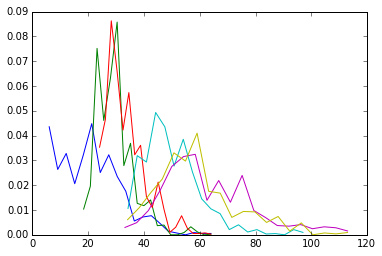

In [18]:
for ens in ensembles[1:]:
    myhist = tis.histograms['pathlength'][ens]
    plt.plot(myhist.plot_bins(), myhist.normalized())